### 初始化
定义工作目录 data_dir

In [13]:
import cooler
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from scipy.stats import mannwhitneyu
from mpl_toolkits.axes_grid1 import make_axes_locatable
import bioframe
import matplotlib.pyplot as plt
from matplotlib import font_manager
import cooltools
from cooltools import insulation
from skimage.filters import threshold_li, threshold_otsu
import bioframe
# import bbi
import pyBigWig
from scipy.stats import ttest_ind

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial'] 
plt.rcParams['pdf.fonttype'] = 42
font_files = font_manager.findSystemFonts(fontpaths='/cluster2/home/futing/miniforge3/envs/juicer/fonts/')
 
for file in font_files:
    font_manager.fontManager.addfont(file)

old_dir='/cluster2/home/futing/Project/panCancer/GBM'
%cd /cluster2/home/futing/Project/panCancer/Analysis/conserve

/cluster2/home/futing/Project/panCancer/Analysis/conserve


#### 比较软件和手动结果

In [ ]:
# calculate the boundary threshold 
boundary_table = pd.read_csv(f'{old_dir}/HiC/09insulation/10k_50k/BS_50k.tsv', sep="\t")
# boundary_table = pd.read_csv(f'{old_dir}/HiC/09insulation/10k_50k/BS_10k_sup_50k.tsv', sep="\t")
boundary_table=boundary_table.iloc[:,1:]
boundary_table = boundary_table.drop(columns=['insul_50k.tsv'])
thresholds_li = {}
thresholds_otsu = {}
thresholds_otsu = boundary_table.apply(lambda x: threshold_otsu(x.dropna().values), axis=0)
thresholds_li = boundary_table.apply(lambda x: threshold_li(x.dropna().values), axis=0)
threshold=boundary_table.apply(lambda x: x>=thresholds_li[x.name], axis=0)

In [ ]:
# cooltools 鉴定的boundary
is_boundary = pd.read_csv(f'{old_dir}/HiC/09insulation/10k_50k/isB_50k.tsv', sep="\t")
is_boundary=is_boundary.drop(columns={'BS2_50k.tsv','BS_50k.tsv','isB_50k.tsv'})

In [124]:
fil=(is_boundary['A172']==True) & (threshold['A172']==False) # 35089 15070 0 258678
boundary_table[fil].shape

(35089, 69)

In [109]:
# 我算的boundary和cooltools算的boundary的一致性
boundary_equal=pd.DataFrame()
for i in range(0, boundary_table.shape[1]):
    boundary_equal[boundary_table.columns[i]]=is_boundary.iloc[:,i]==threshold.iloc[:,i]
boundary_equal.sum(axis=0)

42MGBA    269705
A172      273748
G120      274988
G148      275862
G163      276817
           ...  
ts667     243005
U118      236970
U251      250774
U343      240172
U87       252930
Length: 69, dtype: int64

#### 鉴定 BS

In [ ]:
bin=pd.read_csv(f'/cluster2/home/futing/Project/panCancer/Analysis/conserve/Cancer_335col8.tsv', sep="\t")
meta=pd.read_csv('/cluster2/home/futing/Project/panCancer/check/post/insul/insul0918.txt', sep="\t", header=None, index_col=None)
meta.columns=['cancer','gse','cell','ncell']

In [3]:
# 筛选 NA
threshold=0.5
fil = bin.isna().sum(axis=1) > threshold*bin.shape[1]
bin_fil = bin.loc[~fil,:] #(2212, 330)
bin_any = bin.loc[bin.notna().any(axis=1),:] # 所有的boundary (617665, 330)

In [ ]:
# bin_fil.to_csv('/cluster2/home/futing/Project/panCancer/Analysis/conserve/panCan327_50k800k.bed', sep="\t", index=False)
# bin_any.to_csv('/cluster2/home/futing/Project/panCancer/Analysis/conserve/panCan327_50k800k_any.bed', sep="\t", index=False)

In [3]:
bin_fil = pd.read_csv('/cluster2/home/futing/Project/panCancer/Analysis/conserve/panCan327_50k800k.bed', sep="\t", header=0)
bin_fil.head()

,chrom,start,end,AA86,ALL_PDX17,ALL_PDX19,ALL_PDX29,ALL_PDX34,FLT3-ITD_cHiC,t8_21_cHiC,...,CCRF-CEM,Jurkat_3,MOLT-4,RPMI-8402,Tcell_leukemia_cell,LEIO-PT1063,LEIO-PT848,LEIO-PT886,LEIO-PT916,LEIO-PT967
0,chr1,1570000,1575000,NaN,0.363579,0.310146,0.294529,0.332227,NaN,NaN,...,NaN,0.297442,NaN,0.277949,0.256488,NaN,NaN,NaN,NaN,NaN
1,chr1,3620000,3625000,NaN,0.941321,1.024363,NaN,0.882899,NaN,NaN,...,0.474745,0.602261,0.319031,NaN,0.479819,NaN,NaN,NaN,NaN,NaN
2,chr1,3900000,3905000,NaN,NaN,NaN,NaN,NaN,NaN,0.441490,...,NaN,1.885578,0.425778,NaN,NaN,54.051899,NaN,9.136744,3.218393,2.177751
3,chr1,4860000,4865000,NaN,0.520106,0.388591,0.624578,NaN,NaN,NaN,...,0.273363,0.578399,NaN,0.235227,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,5045000,5050000,NaN,NaN,0.586059,0.588529,NaN,0.243422,0.073241,...,0.864557,0.016253,0.121976,0.415400,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# 计算每个细胞系有多少 conserve boundary
nCB_ratio = bin_fil.iloc[:,3:].notna().mean(axis=0)

# 注释一下
df=pd.merge(nCB_ratio.to_frame(name='non_na_ratio'), meta, left_index=True, right_on='ncell') # 合并 cancer 和 ncell 
df= df.sort_values(by='non_na_ratio', ascending=False) # 按照 non_na_ratio 排序
# df.to_csv('/cluster2/home/futing/Project/panCancer/Analysis/conserve/nCB_ratio_50k800k.tsv', sep="\t", header=True, index=False)

In [5]:
# 计算每个细胞系有多少 boundary
nB_ratio = bin.iloc[:,3:].notna().sum(axis=0)
# nCB_ratio.to_csv('/cluster2/home/futing/Project/panCancer/Analysis/conserve/nCB_50k800k.tsv', sep="\t", header=True)
df=pd.merge(nB_ratio.to_frame(name='non_na_ratio'), meta, left_index=True, right_on='ncell') # 合并 cancer 和 ncell 
df= df.sort_values(by='non_na_ratio', ascending=False) # 按照 non_na_ratio 排序
# df.to_csv('/cluster2/home/futing/Project/panCancer/Analysis/conserve/nB_ratio_50k800k.tsv', sep="\t", header=True, index=False)

In [6]:
nB_ratio.head()

AA86          61478
ALL_PDX17    117446
ALL_PDX19    114357
ALL_PDX29    111633
ALL_PDX34    112451
dtype: int64

In [7]:
bin_fil.shape

(2334, 345)

In [8]:
bin_fil.iloc[:,3:].notna().sum(axis=0).head()

AA86          321
ALL_PDX17    1812
ALL_PDX19    1873
ALL_PDX29    2018
ALL_PDX34    1982
dtype: int64

In [9]:
# 每个细胞系 conserve boundary 的数量/每个细胞系 boundary 的数量 = conserve boundary ratio
nCB_rratio = bin_fil.iloc[:,3:].notna().sum(axis=0) / bin.iloc[:,3:].notna().sum(axis=0)
df=pd.merge(nCB_rratio.to_frame(name='non_na_ratio'), meta, left_index=True, right_on='ncell') # 合并 cancer 和 ncell 
df= df.sort_values(by='non_na_ratio', ascending=False) # 按照 non_na_ratio 排序
# df.to_csv('/cluster2/home/futing/Project/panCancer/Analysis/conserve/nCBmB_ratio_50k800k.tsv', sep="\t", header=True, index=False)

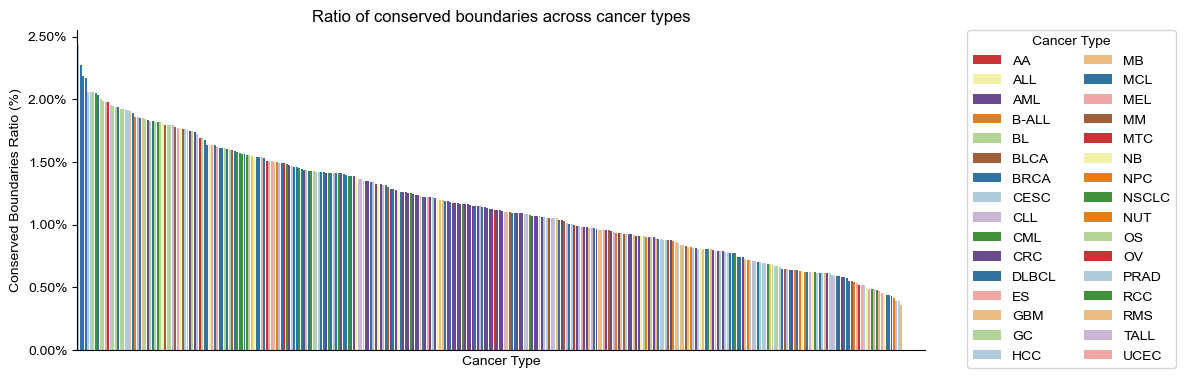

In [14]:
fig, ax = plt.subplots(figsize=(12, 4)) 

# 使用 Paired 调色板，为每种癌症类型分配不同颜色
unique_cancers = df['cancer'].nunique()
set1 = sns.color_palette("Paired", unique_cancers)

# 创建条形图，按癌症类型上色
ax = sns.barplot(x=df.ncell, y=df['non_na_ratio'], 
                 hue=df['cancer'],  # 按癌症类型分组上色
                 palette=set1,      # 使用Paired调色板
                 dodge=False)       # 确保不分开显示

plt.title("Ratio of conserved boundaries across cancer types")
# plt.title("Number of boundaries across cancer types")
plt.xticks([])
plt.xlabel("Cancer Type")
plt.ylabel("Conserved Boundaries Ratio (%)")
sns.despine(top=True, right=True, left=False, bottom=False)

# plt.ylabel("Num of Boundaries")

# 将纵轴改为百分制
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.2%}'))

# 获取 legend 句柄和标签
handles, labels = ax.get_legend_handles_labels()

# 对标签和句柄同时排序（按字母顺序）
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))

# 重新设置 legend
ax.legend(handles, labels, title='Cancer Type',
          bbox_to_anchor=(1.05, 1), loc='upper left',
          borderaxespad=0, ncol=2)

plt.tight_layout()
# plt.savefig('nCB_rratio_50k800k.pdf', dpi=500)

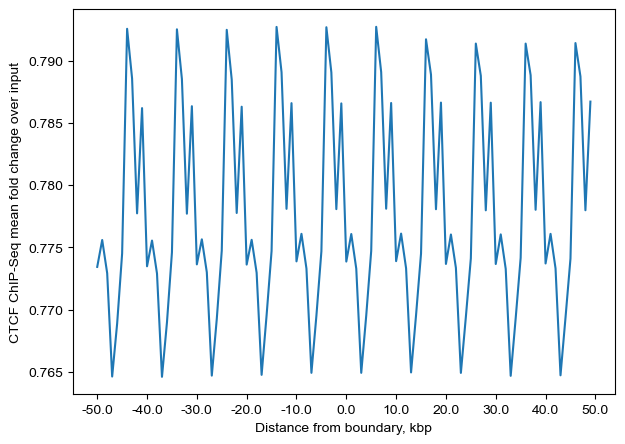

In [ ]:
import bioframe
import bbi
import pyBigWig
# motif score
# ctcf_peak_file = f'{old_dir}/HiC/02data/04mcool/01GBM/CTCF_peaks.bed'
# ctcf = bioframe.read_table(ctcf_peaks_file, schema='bed').query(f'chrom in {clr.chromnames}')

# Create of the stackup, the flanks are +- 50 Kb, number of bins is 100 : 
flank = 50000 # Length of flank to one side from the boundary, in basepairs
nbins = 100   # Number of bins to split the region
resolution = 10000
stackup = bbi.stackup(f'{old_dir}/ChIP/CTCF/Johnson_CTCF/G583_standard/macs2/G583.bw', 
                      bin.chrom, 
                      bin.start+resolution//2-flank, #5000-50000
                      bin.start+resolution//2+flank, #5000+50000
                      bins=nbins) # 结果(930,100)
f, ax = plt.subplots(figsize=[7,5])
ax.plot(np.nanmean(stackup, axis=0) ) # 按照列取均值 (100,)
ax.set(xticks=np.arange(0, nbins+1, 10),
       xticklabels=(np.arange(0, nbins+1, 10)-nbins//2)*flank*2/nbins/1000, 
       # (-50,50)*100000/100/1000
       xlabel='Distance from boundary, kbp',
       ylabel='CTCF ChIP-Seq mean fold change over input');

# 统计注释结果

## bedtools 注释 conserve boundaries 与 gene TSS

In [ ]:
# 上面的保存为 /cluster/home/futing/Project/GBM/HiC/09insulation/insul_futing/conserve_B/10K_50k_cb.bed
# 用bedtools进行注释 导入为boundaries
conserve_boundaries=pd.read_csv(f'{old_dir}/HiC/09insulation/insul_futing/conserve_B/GBM/conBoun_tss.bed',sep="\t",header=None)
conserve_boundaries.rename(columns={0:'chrom',1:'start',2:'end'},inplace=True)

In [11]:
CB_TSS = pd.read_csv('/cluster2/home/futing/Project/panCancer/Analysis/conserve/PCG_panCan327_50k800k.bed',sep='\t',header=None)
CB_TSS = CB_TSS.iloc[:,5:8]

# ChIP signal

### define non-CTCF conserve boundaries

In [ ]:
flank = 1000 # Length of flank to one side from the boundary, in basepairs
ctcf_peak_file = f'{old_dir}/ChIP/CTCF/Johnson_CTCF/G583_standard/macs2/G583.bw'
ctcf_chip_signal = bbi.stackup(
    ctcf_peak_file, 
    conserve_boundaries.chrom, 
    conserve_boundaries.start-flank, 
    conserve_boundaries.end+flank, 
    bins=1).flatten()

In [194]:
non_CTCF_boundaries_conserve = conserve_boundaries[ctcf_chip_signal<2]
CTCF_boundaries_conserve = conserve_boundaries[ctcf_chip_signal>=2]

In [195]:
print(f'Num of non-CTCF boundaries in conserve = {len(non_CTCF_boundaries_conserve)}')
print(f'Num of CTCF boundaries in conserve = {len(CTCF_boundaries_conserve)}')

Num of non-CTCF boundaries in conserve = 3800
Num of CTCF boundaries in conserve = 6294


In [ ]:
non_CTCF_boundaries_conserve.to_csv(f'{old_dir}/HiC/09insulation/insul_futing/conserve_B/non_CTCF_boundaries.bed',sep='\t',index=False)
CTCF_boundaries_conserve.to_csv(f'{old_dir}/HiC/09insulation/insul_futing/conserve_B/CTCF_boundaries.bed',sep='\t',index=False)
#non_CTCF_boundaries_conserve=pd.read_csv(f'{old_dir}/HiC/09insulation/insul_futing/conserve_B/non_CTCF_boundaries.bed',sep='\t',index=False)
#CTCF_boundaries_conserve=pd.read_csv(f'{old_dir}/HiC/09insulation/insul_futing/conserve_B/CTCF_boundaries.bed',sep='\t',index=False)

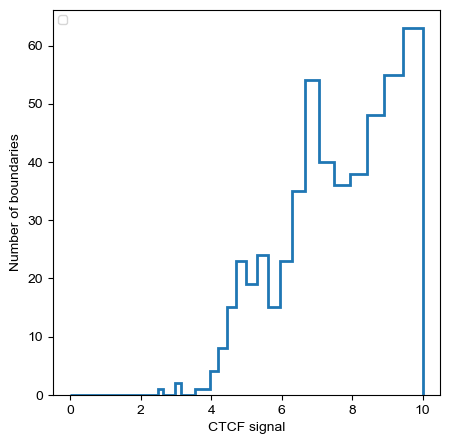

In [222]:
histkwargs = dict(
        bins=10**np.linspace(-4,1,200),
        histtype='step',
        lw=2,
    )

f, ax = plt.subplots(figsize=[5,5])
ax.set( xlabel='CTCF signal', ylabel=f'Number of boundaries')
ax.hist(
    ctcf_chip_signal,
    **histkwargs
)
ax.legend(loc='upper left',fontsize=8)

Text(0.6, 0.8, 'Num of non-CTCF boundaries = 3457')

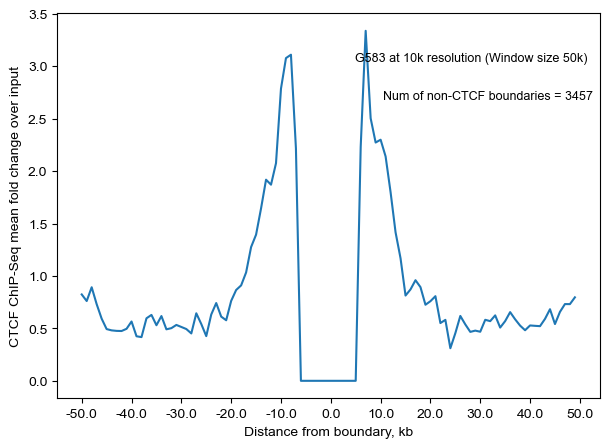

In [ ]:
#boundaries 为三列的bed文件
import bbi
ctcf_peak_file = f'{old_dir}/ChIP/CTCF/Johnson_CTCF/G583_standard/macs2/G583.bw'
flank=50000
nbins=100
cell='G583'
resolution=10000
boundaries=CTCF_boundaries_conserve.iloc[:,0:3].drop_duplicates()
stackup = bbi.stackup(ctcf_peak_file, 
                        boundaries.chrom, 
                        boundaries.start+resolution//2-flank, #5000-50000
                        boundaries.start+resolution//2+flank, #5000+50000
                        bins=nbins) # 结果(930,100)
f, ax = plt.subplots(figsize=[7,5])
ax.plot(np.nanmean(stackup, axis=0) ) # 按照列取均值 (100,)
ax.set(xticks=np.arange(0, nbins+1, 10),
    xticklabels=(np.arange(0, nbins+1, 10)-nbins//2)*flank*2/nbins/1000, 
    # (-50,50)*100000/100/1000
    xlabel='Distance from boundary, kb',
    ylabel='CTCF ChIP-Seq mean fold change over input');
ax.text(0.55, 0.9, f'{cell} at 10k resolution (Window size 50k)', ha='left', va='top', transform=ax.transAxes,fontsize=9)
ax.text(0.6,0.8,f'Num of non-CTCF boundaries = {len(boundaries)}',ha='left',va='top',transform=ax.transAxes,fontsize=9)
#f.savefig(ff'{old_dir}/HiC/09insulation/insul_futing/CTCF_{cell}_10k.pdf', format='pdf', dpi=500, bbox_inches='tight', pad_inches=0.5)





Text(0.6, 0.8, 'Num of CTCF boundaries = 6294')

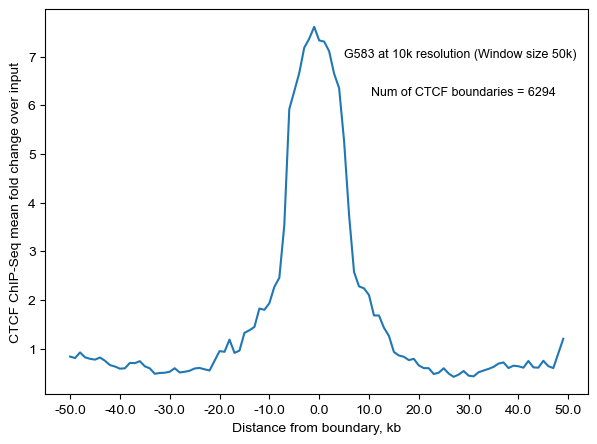

In [ ]:
ctcf_peak_file = f'{old_dir}/ChIP/CTCF/Johnson_CTCF/G583_standard/macs2/G583.bw'
flank=50000
nbins=100
cell='G583'
stackup = bbi.stackup(ctcf_peak_file, 
                        CTCF_boundaries_conserve.chrom, 
                        CTCF_boundaries_conserve.start+resolution//2-flank, #5000-50000
                        CTCF_boundaries_conserve.start+resolution//2+flank, #5000+50000
                        bins=nbins) # 结果(930,100)
f, ax = plt.subplots(figsize=[7,5])
ax.plot(np.nanmean(stackup, axis=0) ) # 按照列取均值 (100,)
ax.set(xticks=np.arange(0, nbins+1, 10),
    xticklabels=(np.arange(0, nbins+1, 10)-nbins//2)*flank*2/nbins/1000, 
    # (-50,50)*100000/100/1000
    xlabel='Distance from boundary, kb',
    ylabel='CTCF ChIP-Seq mean fold change over input');
ax.text(0.55, 0.9, f'{cell} at 10k resolution (Window size 50k)', ha='left', va='top', transform=ax.transAxes,fontsize=9)
ax.text(0.6,0.8,f'Num of CTCF boundaries = {len(CTCF_boundaries_conserve)}',ha='left',va='top',transform=ax.transAxes,fontsize=9)
#f.savefig(ff'{old_dir}/HiC/09insulation/insul_futing/CTCF_{cell}_10k.pdf', format='pdf', dpi=500, bbox_inches='tight', pad_inches=0.5)



### define non-CTCF boundary in GBM and NPC

In [ ]:
windows = [3*resolution, 5*resolution, 10*resolution, 25*resolution]
cool_file =f'{old_dir}/HiC/02data/03cool/10000/G583_10000.cool'
ctcf_peak_file = f'{old_dir}/ChIP/CTCF/Johnson_CTCF/G583_standard/macs2/G583.bw'
clr = cooler.Cooler(cool_file)
#insulation_table = insulation(clr, windows, verbose=True,ignore_diags=2)
insulation_table=pd.read_csv(f'{old_dir}/HiC/09insulation/insul_futing/50k/G583_insul.tsv',sep='\t')


In [ ]:
NPC= cooler.Cooler(NPC_cool_path)
#insulation_table_NPC = insulation(NPC, windows, verbose=True,ignore_diags=2)
insulation_table_NPC=pd.read_csv(f'{old_dir}/HiC/09insulation/insul_futing/NPC_insul.tsv',sep='\t')


In [ ]:
def get_ctcf_boundary_sig(cell,cool_file,ctcf_peak_file,insulation_table=None,flank=1000,resolution=10000):
    # 01 calculate the boundary threshold
    windows = [3*resolution, 5*resolution, 10*resolution, 25*resolution]
    if insulation_table is None:
        clr = cooler.Cooler(cool_file)
        insulation_table = insulation(clr, windows, verbose=True,ignore_diags=2)
    #w=windows[1]
    is_boundary = np.any([
            ~insulation_table[f'boundary_strength_{w}'].isnull() 
            for w in windows],
        axis=0)
    boundaries = insulation_table[is_boundary]
    
    thresholds_li = {}
    thresholds_otsu = {}
    for w in windows:
        thresholds_li[w] = threshold_li(insulation_table[f'boundary_strength_{w}'].dropna().values)
        thresholds_otsu[w] = threshold_otsu(insulation_table[f'boundary_strength_{w}'].dropna().values)
    # Select the strict thresholded boundaries for one window size
    top_boundaries = insulation_table[insulation_table[f'boundary_strength_{windows[1]}']>=thresholds_otsu[windows[1]]]
    top_strict_boundaries = boundaries[boundaries[f'boundary_strength_{windows[1]}']>=thresholds_otsu[windows[1]]]
    print(f'Num of top boundaries = {len(top_boundaries)}')
    print(f'Num of strict boundaries = {len(boundaries)}')
    print(f'Num of top strict boundaries = {len(top_strict_boundaries)}')

    # 02 Calculate the average ChIP singal/input in the 3kb region around the boundary.  
    flank = 1000 # Length of flank to one side from the boundary, in basepairs
    ctcf_chip_signal = bbi.stackup(
        ctcf_peak_file, 
        boundaries.chrom, 
        boundaries.start-flank, 
        boundaries.end+flank, 
        bins=1).flatten()
    return ctcf_chip_signal,boundaries,top_boundaries,top_strict_boundaries,thresholds_li,thresholds_otsu


In [ ]:
G583_CTCF,G583_boundaries,G583_top_boundaries,G583_top_strict_boundaries,G583_th_li,G583_th_otsu=get_ctcf_boundary_sig(cell='G583',cool_file=cool_file,ctcf_peak_file=ctcf_peak_file,insulation_table=insulation_table)

Num of top boundaries = 6881
Num of strict boundaries = 103597
Num of top strict boundaries = 6881


In [ ]:
NPC_CTCF,NPC_boundaries,NPC_top_boundaries,NPC_top_strict_boundaries,NPC_th_li,NPC_th_otsu =get_ctcf_boundary_sig(cell='NPC',cool_file=NPC_cool_path,ctcf_peak_file=NPC_ctcf_peak_file,insulation_table=insulation_table_NPC)

Num of top boundaries = 6383
Num of strict boundaries = 122421
Num of top strict boundaries = 6383


In [ ]:
non_CTCF_boundaries_G583 = G583_boundaries[G583_CTCF<2]
non_CTCF_boundaries_NPC = NPC_boundaries[NPC_CTCF<2]
non_CTCF_boundaries_G583.to_csv(f'{old_dir}/HiC/09insulation/insul_futing/non_CTCF_boundaries_G583.tsv',sep='\t',index=False)
non_CTCF_boundaries_NPC.to_csv(f'{old_dir}/HiC/09insulation/insul_futing/non_CTCF_boundaries_NPC.tsv',sep='\t',index=False)

In [ ]:
print(f'Num of non-CTCF boundaries in G583 = {len(non_CTCF_boundaries_G583)}')
print(f'Num of non-CTCF boundaries in NPC = {len(non_CTCF_boundaries_NPC)}')
print(f'Proportion of non-CTCF boundaries in G583 = {len(non_CTCF_boundaries_G583) / len(G583_boundaries):.2f}')
print(f'Proportion of non-CTCF boundaries in NPC = {len(non_CTCF_boundaries_NPC) / len(NPC_boundaries):.2f}')

Num of non-CTCF boundaries in G583 = 80633
Num of non-CTCF boundaries in NPC = 98915
Proportion of non-CTCF boundaries in G583 = 0.78
Proportion of non-CTCF boundaries in NPC = 0.81


In [ ]:
(boundaries[f'boundary_strength_{w}'].min(),boundaries[f'boundary_strength_{w}'].max()),(ctcf_chip_signal.min(),ctcf_chip_signal.max())

((3.465442703146082e-07, 6.962892053189702), (0.0, 121.85649871826172))

### CTCF signal 折线图

In [ ]:
%%bash
cooler balance f'{old_dir}/HiC/02data/03cool/10000/NPC_10000.cool'

In [ ]:

def plot_ctcf_sig(cell,cool_path,ctcf_peak_file,resolution=10000,flank=50000,nbins=100):
    thresholds_li = {}
    thresholds_otsu = {} 
    clr = cooler.Cooler(cool_path)
    windows = [3*resolution, 5*resolution, 10*resolution, 25*resolution]
    insulation_table = insulation(clr, windows, verbose=True,ignore_diags=2)
    w=windows[1]
    thresholds_li[w] = threshold_li(insulation_table[f'boundary_strength_{w}'].dropna().values)
    thresholds_otsu[w] = threshold_otsu(insulation_table[f'boundary_strength_{w}'].dropna().values)
    # Select the strict thresholded boundaries for one window size
    top_boundaries = insulation_table[insulation_table[f'boundary_strength_{windows[1]}']>=thresholds_otsu[windows[1]]]
    print(f'Num of top boundaries = {len(top_boundaries)}')


    stackup = bbi.stackup(ctcf_peak_file, 
                        top_boundaries.chrom, 
                        top_boundaries.start+resolution//2-flank, #5000-50000
                        top_boundaries.start+resolution//2+flank, #5000+50000
                        bins=nbins) # 结果(930,100)
    f, ax = plt.subplots(figsize=[7,5])
    ax.plot(np.nanmean(stackup, axis=0) ) # 按照列取均值 (100,)
    ax.set(xticks=np.arange(0, nbins+1, 10),
        xticklabels=(np.arange(0, nbins+1, 10)-nbins//2)*flank*2/nbins/1000, 
        # (-50,50)*100000/100/1000
        xlabel='Distance from boundary, kb',
        ylabel='CTCF ChIP-Seq mean fold change over input');
    ax.text(0.02, 0.9, f'{cell} at 10k resolution (Window size 50k)', ha='left', va='top', transform=ax.transAxes,fontsize=9)
    ax.text(0.02,0.8,f'Num of top boundaries = {len(top_boundaries)}',ha='left',va='top',transform=ax.transAxes,fontsize=9)
    f.savefig(ff'{old_dir}/HiC/09insulation/insul_futing/CTCF_{cell}_10k.pdf', format='pdf', dpi=500, bbox_inches='tight', pad_inches=0.5)





INFO:root:Processing region chr1
INFO:root:Processing region chr2
INFO:root:Processing region chr3
INFO:root:Processing region chr4
INFO:root:Processing region chr5
INFO:root:Processing region chr6
INFO:root:Processing region chr7
INFO:root:Processing region chr8
INFO:root:Processing region chr9
INFO:root:Processing region chr10
INFO:root:Processing region chr11
INFO:root:Processing region chr12
INFO:root:Processing region chr13
INFO:root:Processing region chr14
INFO:root:Processing region chr15
INFO:root:Processing region chr16
INFO:root:Processing region chr17
INFO:root:Processing region chr18
INFO:root:Processing region chr19
INFO:root:Processing region chr20
INFO:root:Processing region chr21
INFO:root:Processing region chr22
INFO:root:Processing region chrX
INFO:root:Processing region chrY


Num of top boundaries = 6881


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 52 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 'D', 'F', 'G', 'I', 'N', 'P', 'S', 'T', 'W', 'a', 'b', 'c', 'comma', 'd', 'e', 'eight', 'equal', 'f', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'period', 'q', 'r', 's', 'six', 'space', 't', 'three', 'two', 'u', 'v', 'w', 'y', 'z', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 27, 32,

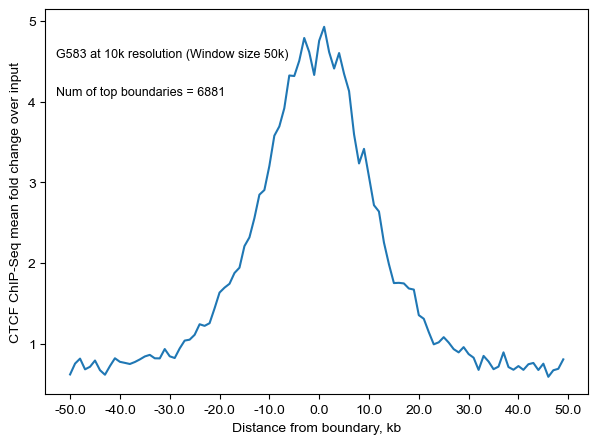

In [ ]:
# Create of the stackup, the flanks are +- 50 Kb, number of bins is 100 : 
flank = 50000 # Length of flank to one side from the boundary, in basepairs
nbins = 100   # Number of bins to split the region
resolution = 10000
windows = [3*resolution, 5*resolution, 10*resolution, 25*resolution]
cell='G583'
cool_file =f'{old_dir}/HiC/02data/03cool/10000/G583_10000.cool'
ctcf_peak_file = f'{old_dir}/ChIP/CTCF/Johnson_CTCF/G583_standard/macs2/G583.bw'
NPC_ctcf_peak_file = f'{old_dir}/ChIP/CTCF/G583/macs2/G583.bw'
NPC_cool_path=f'{old_dir}/HiC/02data/03cool/10000/NPC_new_10000.cool'
plot_ctcf_sig(cell='G583',cool_path=cool_file,ctcf_peak_file=ctcf_peak_file)


### CTCF and BS 散点图

In [ ]:


'''
ax.loglog(
    boundaries[f'boundary_strength_{w}'], 
    ctcf_chip_signal,
    'o',
    markersize=1,
    alpha=0.05
);
'''
def plot_BS_CTCF(cell,ctcf_chip_signal,boundaries,thresholds_otsu,thresholds_li,resolution=10000):
    windows = [3*resolution, 5*resolution, 10*resolution, 25*resolution]
    w=windows[0]
    f, ax = plt.subplots()
    sns.scatterplot(
        x=boundaries[f'boundary_strength_{w}'], 
        y=ctcf_chip_signal,size=1, alpha=0.05,legend=False
    )

    ax.set(
        #xlim=(1e-4,1e1),
        #ylim=(3e-2,3e1),
        xscale='log',
        yscale='log',
        xlabel='Boundary strength',
        ylabel=f'CTCF enrichment over input in {cell}')

    ax.axvline(thresholds_otsu[w], ls='--', color='magenta', label='Otsu threshold')
    ax.axvline(thresholds_li[w], ls='--', color='green', label='Li threshold')
    ax.legend(title='Thresholds')
    ax.text(0.02, 0.8, f'{cell} at 10k resolution (Window size 30k)', ha='left', va='top', transform=ax.transAxes,fontsize=9)
    plt.savefig(ff'{old_dir}/HiC/09insulation/insul_futing/CTCF_BS_{cell}_10k.pdf', format='pdf', dpi=500, bbox_inches='tight', pad_inches=0.5)

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 44 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'B', 'C', 'F', 'G', 'L', 'O', 'T', 'W', 'a', 'c', 'd', 'e', 'eight', 'five', 'four', 'g', 'h', 'i', 'k', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'r', 's', 'six', 'space', 't', 'three', 'two', 'u', 'v', 'w', 'y', 'z', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 19, 20, 21, 22, 23, 24, 25, 27, 37, 38, 41, 42, 47, 50, 55, 58, 68, 70, 71, 72, 74, 75, 76, 78, 79, 8

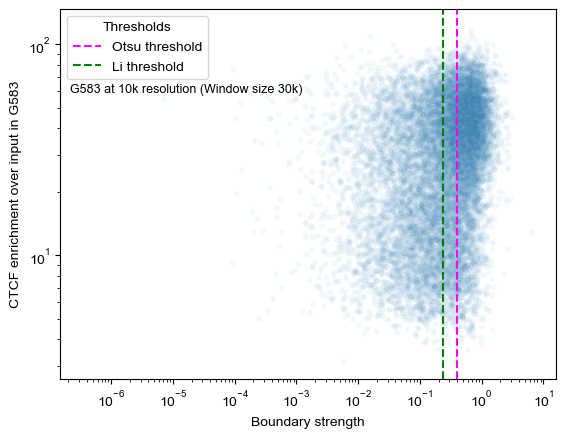

In [ ]:
plot_BS_CTCF(cell='G583',ctcf_chip_signal=G583_CTCF,boundaries=G583_boundaries,thresholds_li=G583_th_li,thresholds_otsu=G583_th_otsu)

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 43 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'B', 'C', 'F', 'L', 'N', 'O', 'P', 'T', 'W', 'a', 'c', 'd', 'e', 'five', 'four', 'g', 'h', 'i', 'k', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'r', 's', 'space', 't', 'three', 'two', 'u', 'v', 'w', 'y', 'z', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 19, 20, 21, 22, 23, 24, 37, 38, 41, 47, 49, 50, 51, 55, 58, 68, 70, 71, 72, 74, 75, 76, 78, 79, 80, 81, 82, 83, 

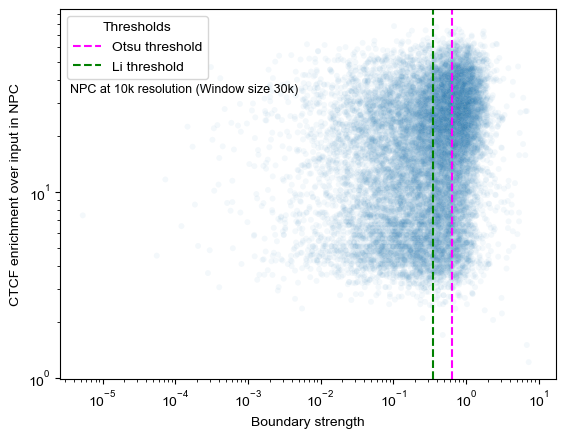

In [ ]:
plot_BS_CTCF(cell='NPC',ctcf_chip_signal=NPC_CTCF,boundaries=NPC_boundaries,thresholds_li=NPC_th_li,thresholds_otsu=NPC_th_otsu)

### CTCF and BS 分布直方图

In [ ]:
def plot_BS_CTCF_hist(cell,ctcf_chip_signal,boundaries,non_CTCF_boundaries,resolution=10000):
    histkwargs = dict(
        bins=10**np.linspace(-4,1,200),
        histtype='step',
        lw=2,
    )
    num_NC=len(non_CTCF_boundaries)
    num_C=len(boundaries)-num_NC
    num_all=len(boundaries)
    f, ax = plt.subplots()
    ax.set(xscale='log', xlabel='Boundary strength', ylabel=f'Number of boundaries in {cell}')
    ax.hist(
        boundaries[f'boundary_strength_{windows[0]}'][ctcf_chip_signal>=2],
        label=f'CTCF Chip/Input ≥ 2.0: {num_C} ({num_C*100/num_all:.2f}%)',
        **histkwargs
    );
    ax.hist(
        boundaries[f'boundary_strength_{windows[0]}'][ctcf_chip_signal<2],
        label=f'CTCF Chip/Input < 2.0: {num_NC} ({num_NC*100/num_all:.2f}%)',
        **histkwargs
    );
    ax.hist(
        boundaries[f'boundary_strength_{windows[0]}'],
        label=f'all boundaries: {num_all}',
        **histkwargs
    );
    ax.legend(loc='upper left',fontsize=8)

    plt.savefig(ff'{old_dir}/HiC/09insulation/insul_futing/CTCF_{cell}_hist.pdf', format='pdf', dpi=500, bbox_inches='tight', pad_inches=0.5)

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 47 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'B', 'C', 'F', 'I', 'N', 'P', 'T', 'a', 'b', 'colon', 'd', 'e', 'eight', 'f', 'five', 'four', 'g', 'greaterequal', 'h', 'i', 'l', 'less', 'm', 'minus', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'percent', 'period', 'r', 's', 'six', 'slash', 'space', 't', 'three', 'two', 'u', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 8, 11, 12, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29,

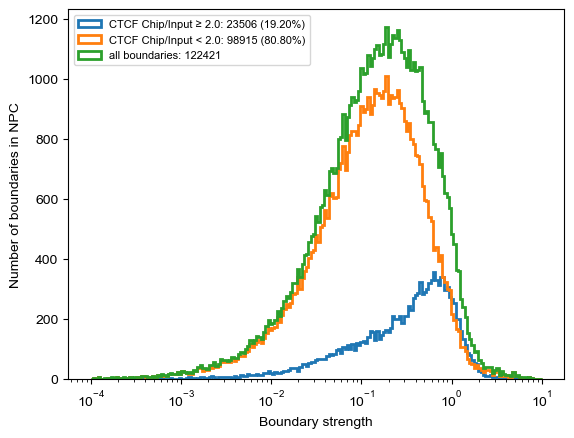

In [28]:
plot_BS_CTCF_hist(cell='NPC',ctcf_chip_signal=NPC_CTCF,boundaries=NPC_boundaries,non_CTCF_boundaries=non_CTCF_boundaries_NPC)

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 48 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'B', 'C', 'F', 'G', 'I', 'N', 'T', 'a', 'b', 'colon', 'd', 'e', 'eight', 'f', 'five', 'four', 'g', 'greaterequal', 'h', 'i', 'l', 'less', 'm', 'minus', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'percent', 'period', 'r', 's', 'seven', 'six', 'slash', 'space', 't', 'three', 'two', 'u', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 8, 11, 12, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26

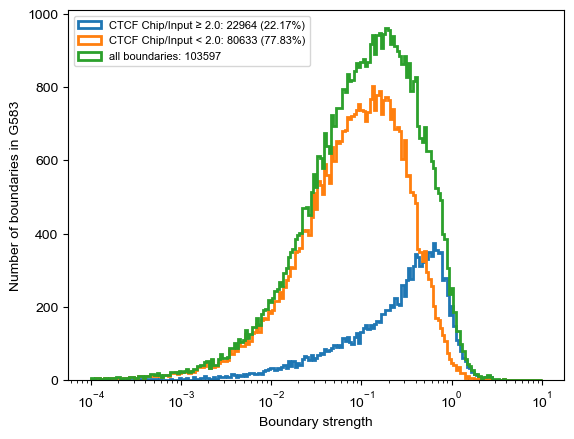

In [27]:
plot_BS_CTCF_hist(cell='G583',ctcf_chip_signal=G583_CTCF,boundaries=G583_boundaries,non_CTCF_boundaries=non_CTCF_boundaries_G583)

# CGC distribution

In [4]:
iPSC=[78*100/742,66400/742,12*100/99,8700/99]
NPC=[61*100/742,68100/742,4*100/99,9500/99]
GBM=[111*100/742,63100/742,21*100/99,7800/99]
df=pd.DataFrame({'GBM':GBM,'iPSC':iPSC,'NPC':NPC},index=['CGC in boundaries','CGC not in boundaries','GBM-CGC in boundaries','GBM-CGC not in boundaries'])

In [49]:
iPSC=[78*100/742,66400/742,12*100/99,8700/99]
NPC=[61*100/742,68100/742,4*100/99,9500/99]
GBM=[714*100/742,2800/742,93*100/99,600/99]
df=pd.DataFrame({'GBM':GBM,'iPSC':iPSC,'NPC':NPC},index=['CGC in boundaries','CGC not in boundaries','GBM-CGC in boundaries','GBM-CGC not in boundaries'])

In [ ]:
df.to_csv(f'{old_dir}/HiC/09insulation/insul_futing/CGC_in_boundaries.tsv',sep='\t')
df

,GBM,iPSC,NPC
CGC in boundaries,14.959569,10.512129,8.221024
CGC not in boundaries,85.040431,89.487871,91.778976
GBM-CGC in boundaries,21.212121,12.121212,4.040404
GBM-CGC not in boundaries,78.787879,87.878788,95.959596


In [50]:
import numpy as np
from scipy.stats import chi2_contingency

# 创建一个2x2的列联表（四格表）
# 例如：[ [实验组成功, 实验组失败], [对照组成功, 对照组失败] ]
data = df.iloc[2:4,[0,1]].T.values

# 进行卡方检验
chi2, p, dof, expected = chi2_contingency(data)

# 输出结果
print(f"卡方统计量: {chi2}")
print(f"p值: {p}")
print(f"自由度: {dof}")
print(f"期望频数: \n{expected}")


卡方统计量: 131.11316129032255
p值: 2.338860018818755e-30
自由度: 1
期望频数: 
[[53.03030303 46.96969697]
 [53.03030303 46.96969697]]


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 35 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'B', 'C', 'D', 'G', 'M', 'N', 'P', 'S', 'a', 'b', 'c', 'd', 'e', 'eight', 'f', 'four', 'hyphen', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'six', 'space', 't', 'two', 'u', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 19, 20, 21, 23, 25, 27, 37, 38, 39, 42, 48, 49, 51, 54, 68, 69, 70, 71, 72, 73, 76, 79, 81, 82, 83, 85, 86, 87, 88, 92]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 

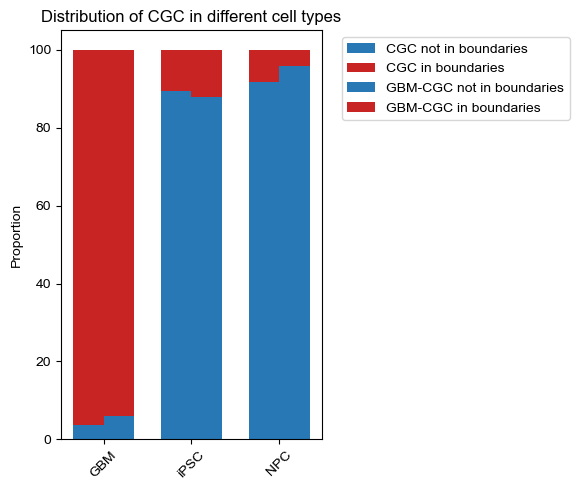

In [ ]:
# 设置柱子的位置和宽度
n_groups = len(df.columns)  # 有多少组
bar_width = 0.35  # 每组两根柱子的宽度
index = np.arange(n_groups)  # 定义x轴位置

# 设置颜色
colors = [ '#C82423','#2878B5']  # 第一行和第三行一种颜色，第二行和第四行另一种颜色

# 绘制堆叠柱状图
fig, ax = plt.subplots(figsize=(6, 5))

# 绘制第一组（Row1+Row2 和 Row3+Row4）的堆叠柱子
bar2 = ax.bar(index, df.iloc[1], bar_width, label=df.index[1], color=colors[1])  # 第二行
bar1 = ax.bar(index, df.iloc[0], bar_width, bottom=df.iloc[1],label=df.index[0], color=colors[0])  # 第一行
bar4 = ax.bar(index + bar_width, df.iloc[3], bar_width, label=df.index[3], color=colors[1])  # 第四行
bar3 = ax.bar(index + bar_width, df.iloc[2], bar_width, bottom=df.iloc[3], label=df.index[2], color=colors[0])  # 第三行


# 添加标签和标题
ax.set_ylabel('Proportion')
ax.set_title('Distribution of CGC in different cell types')
ax.set_xticks(index + bar_width / 2)  # x轴标签的位置
ax.set_xticklabels(df.columns,rotation=45)  # x轴标签的名字

# 添加图例
ax.legend(loc='upper left',bbox_to_anchor=(1.05,1),ncol=1)

# 显示图形
plt.tight_layout()
plt.savefig(f'{old_dir}/HiC/09insulation/con_Boun/CGC_all_bound.pdf', format='pdf', dpi=500, bbox_inches='tight', pad_inches=0.5)

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 34 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'B', 'C', 'D', 'G', 'M', 'N', 'P', 'S', 'a', 'asterisk', 'b', 'd', 'e', 'eight', 'f', 'four', 'hyphen', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'six', 'space', 't', 'two', 'u', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 13, 16, 19, 20, 21, 23, 25, 27, 37, 38, 39, 42, 48, 49, 51, 54, 68, 69, 71, 72, 73, 76, 79, 81, 82, 83, 85, 86, 87, 88]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 34

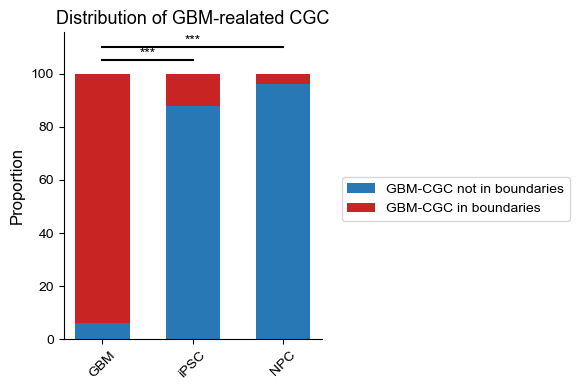

In [ ]:

# 绘制堆叠柱状图
#df[0:2].T.plot(kind='bar', stacked=True, color = ['#C82423', '#2878B5'])
def add_significance(ax, x1, x2, y, p_value, h=0.05, text_offset=0.02):
    """在柱状图上添加显著性标记"""
    if p_value < 0.001:
        stars = "***"
    elif p_value < 0.01:
        stars = "**"
    elif p_value < 0.05:
        stars = "*"
    else:
        stars = "n.s."  # 不显著

    # 添加水平线和星号
    ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c='black')
    ax.text((x1 + x2) * .5, y + h + text_offset, stars, ha='center', va='bottom', color='black')

fig, ax = plt.subplots(figsize=(6, 4))
bar_width = 0.6  # 每组两根柱子的宽度
p_value_12,p_value_13=0.00000012474893575817218,0.0006

# 设置颜色
colors = [ '#C82423','#2878B5']  # 第一行和第三行一种颜色，第二行和第四行另一种颜色
columns = np.arange(df.shape[1])
#columns = np.array([0.5,1.5,2.5])  

# 绘制堆叠柱状图
plt.bar(columns, df.iloc[3], bar_width, label=df.index[3],color=colors[1])
plt.bar(columns, df.iloc[2], bar_width, bottom=df.iloc[3], label=df.index[2], color=colors[0])

# 在组之间添加显著性标记
add_significance(ax, 0, 1, 105, p_value_12)  # group1 vs group2
add_significance(ax, 0, 2, 110, p_value_13)  # group1 vs group3


ax.set_ylabel('Proportion',fontsize=12)
ax.set_title('Distribution of GBM-realated CGC',fontsize=13)
ax.set_xticks(columns)  
ax.set_xticklabels(df.columns,rotation=45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# 添加图例
ax.legend(loc='upper left',bbox_to_anchor=(1.05,0.55),ncol=1)

# 显示图形
plt.tight_layout()
plt.savefig(f'{old_dir}/HiC/09insulation/GBM-related_distri.pdf', format='pdf', dpi=500, bbox_inches='tight', pad_inches=0.5)

In [ ]:
# 先找有H3K27ac的boundary
conserve_boundaries=pd.read_csv(f'{old_dir}/HiC/09insulation/insul_futing/conserve_B/GBM/10K_50k_cb.bed',sep="\t",header=None)
GBM_H3K27ac=f'{old_dir}/ChIP/H3K27ac/Johnson_H3K27ac/G523/macs2/G583_idr_H3K27ac.bed'
GBM_H3K27ac_bw=f'{old_dir}/ChIP/H3K27ac/Johnson_H3K27ac/G523/macs2/G583.bw'
conserve_boundaries.rename(columns={0:'chrom',1:'start',2:'end'},inplace=True)

In [25]:
flank = 1000 # Length of flank to one side from the boundary, in basepairs

H3K27ac_chip_signal = bbi.stackup(
    GBM_H3K27ac_bw, 
    conserve_boundaries.chrom, 
    conserve_boundaries.start-flank, 
    conserve_boundaries.end+flank, 
    bins=1).flatten()

In [ ]:
H3K27ac_boundaries = conserve_boundaries[H3K27ac_chip_signal>=2]
non_H3K27ac_boundaries = conserve_boundaries[H3K27ac_chip_signal<2]

In [27]:
H3K27ac_chip_signal.min(),H3K27ac_chip_signal.max()

(0.0, 62.716800689697266)

In [43]:
H3K27ac_chip_signal[H3K27ac_chip_signal<=1].max()

0.0

[Text(0.5, 0, 'H3K27ac signal'), Text(0, 0.5, 'Number of boundaries')]

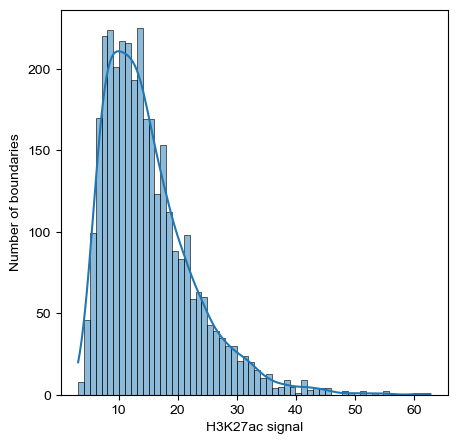

In [39]:
# 使用 seaborn 绘制直方图并加上核密度估计曲线
H3K27ac_chip_signal_fil=H3K27ac_chip_signal[H3K27ac_chip_signal>3]
f, ax = plt.subplots(figsize=[5,5])
sns.histplot(H3K27ac_chip_signal_fil, bins=60, kde=True, edgecolor='black')
ax.set( xlabel='H3K27ac signal', ylabel=f'Number of boundaries')




# 找CGC对应的compartment